# Train-Test Split Experimentation

**Objective:** Investigate how different data splitting strategies affect model performance.

## Overview

Train-test splitting is one of the most fundamental concepts in machine learning. The way we split our data can significantly impact model evaluation and real-world performance. In this notebook, we'll explore three critical splitting strategies and understand when and why to use each one.

Making the wrong choice can lead to:
- Overly optimistic performance estimates
- Models that fail in production
- Misleading conclusions about model quality
- Wasted time and resources

## Topics Covered:

### 1. **Basic Split Analysis**
We'll experiment with different train-test ratios (60/40, 70/30, 80/20, 90/10) to understand the fundamental trade-off: more training data helps the model learn better, but we also need sufficient test data for reliable evaluation.

### 2. **Stratified Splitting**
For imbalanced classification problems where some classes are rare, we'll learn how stratified splitting ensures that both training and test sets maintain the same class distribution as the original dataset.

### 3. **Time-Series Splitting**
When working with temporal data, we must respect the flow of time. We'll explore why random splitting causes data leakage and implement walk-forward validation that mimics real-world deployment scenarios.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✓ Libraries imported successfully!")
print("\nWe'll be using:")
print("  • pandas & numpy: Data manipulation")
print("  • matplotlib & seaborn: Visualization")
print("  • sklearn: Machine learning models and splitting strategies")
print("  • LogisticRegression: Our classification model (simple, interpretable)")
print("  • Various splitting methods: train_test_split, TimeSeriesSplit, etc.")

✓ Libraries imported successfully!

We'll be using:
  • pandas & numpy: Data manipulation
  • matplotlib & seaborn: Visualization
  • sklearn: Machine learning models and splitting strategies
  • LogisticRegression: Our classification model (simple, interpretable)
  • Various splitting methods: train_test_split, TimeSeriesSplit, etc.


## Load and Prepare Data

Before we begin our splitting experiments, we need to load and prepare our dataset. We'll be working with a patient hospital dataset that includes information about:
- Patient demographics (age)
- Service type (emergency, ICU, surgery, general medicine)
- Satisfaction scores
- Temporal information (arrival and departure dates)

This dataset is perfect for our experiments because it has:
- **Class imbalance** - ideal for testing stratified splitting
- **Temporal ordering** - perfect for time-series splitting experiments
- **Multiple features** - sufficient complexity for model training

In [4]:
# Load the patients dataset
df = pd.read_csv('patients.csv')

# Display basic information about our dataset
print("Dataset Shape:", df.shape)
print("=" * 60)

print("\nFirst few rows:")
display(df.head())

print("\n" + "=" * 60)
print("Data Info:")
print("=" * 60)
print(df.info())

print("\n" + "=" * 60)
print("Class Distribution (Service Type):")
print("=" * 60)
print(df['service'].value_counts())
print("\nThis distribution will be important for Section 2 (Stratified Splitting)")
print("We can already see if classes are balanced or imbalanced")

Dataset Shape: (1000, 7)

First few rows:


,patient_id,name,age,arrival_date,departure_date,service,satisfaction
0,PAT-09484753,Kemi Ugwu,24,2025-03-16,2025-03-22,surgery,61
1,PAT-f0644084,Bilkisu Kuti,6,2025-12-13,2025-12-14,surgery,83
2,PAT-ac6162e4,Afamefuna Obi,24,2025-06-29,2025-07-05,general_medicine,83
3,PAT-3dda2bb5,Amina Okoye,32,2025-10-12,2025-10-23,emergency,81
4,PAT-08591375,Chinedu Olusegun,25,2025-02-18,2025-02-25,ICU,76



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_id      1000 non-null   object
 1   name            1000 non-null   object
 2   age             1000 non-null   int64 
 3   arrival_date    1000 non-null   object
 4   departure_date  1000 non-null   object
 5   service         1000 non-null   object
 6   satisfaction    1000 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 54.8+ KB
None

Class Distribution (Service Type):
service
emergency           263
surgery             254
general_medicine    242
ICU                 241
Name: count, dtype: int64

This distribution will be important for Section 2 (Stratified Splitting)
We can already see if classes are balanced or imbalanced


In [5]:
# Prepare features and target variable

# Convert dates to datetime for temporal analysis
df['arrival_date'] = pd.to_datetime(df['arrival_date'])
df['departure_date'] = pd.to_datetime(df['departure_date'])

# Create additional features that might be predictive
df['length_of_stay'] = (df['departure_date'] - df['arrival_date']).dt.days  # Hospital stay duration
df['arrival_month'] = df['arrival_date'].dt.month  # Seasonal patterns
df['arrival_day_of_week'] = df['arrival_date'].dt.dayofweek  # Weekday effects

# Sort by arrival date - CRITICAL for time-series experiments
# This ensures temporal ordering is preserved
df = df.sort_values('arrival_date').reset_index(drop=True)

# Select features for modeling
# We're using demographic, satisfaction, and temporal features
feature_cols = ['age', 'satisfaction', 'length_of_stay', 'arrival_month', 'arrival_day_of_week']
X = df[feature_cols]

# Target variable: service type (this is a multi-class classification problem)
# We encode the categorical service types as numeric labels
le = LabelEncoder()
y = le.fit_transform(df['service'])

print("Feature Matrix Shape:", X.shape)
print("Target Vector Shape:", y.shape)
print("\nClass Labels:", le.classes_)
print("Class Encoding:", dict(zip(le.classes_, le.transform(le.classes_))))

Feature Matrix Shape: (1000, 5)
Target Vector Shape: (1000,)

Class Labels: ['ICU' 'emergency' 'general_medicine' 'surgery']
Class Encoding: {'ICU': np.int64(0), 'emergency': np.int64(1), 'general_medicine': np.int64(2), 'surgery': np.int64(3)}


---
# 1. Basic Split Analysis

## Understanding Train-Test Ratios

The most common question in machine learning is: "What split ratio should I use?" The answer isn't one-size-fits-all. The split ratio represents a fundamental trade-off:

**More Training Data:**
- ✓ Model has more examples to learn from
- ✓ Better pattern recognition
- ✓ Reduced underfitting
- ✗ Smaller test set means less reliable evaluation

**More Test Data:**
- ✓ More reliable performance estimates
- ✓ Better confidence in generalization
- ✗ Less data for the model to learn from
- ✗ Potential underfitting with small training sets

In this section, we'll experiment with four common ratios (60/40, 70/30, 80/20, 90/10) and measure their impact on model performance. We'll also analyze the bias-variance tradeoff to understand when a model is overfitting or underfitting.

### 1.1 Implement train-test splits with different ratios

We'll systematically test four different split ratios and train a logistic regression model on each. By comparing training accuracy vs test accuracy, we can identify potential overfitting and understand how the amount of training data affects model performance.

In [6]:
# Define different split ratios (train/test)
split_ratios = [
    (0.60, 0.40, '60/40'),
    (0.70, 0.30, '70/30'),
    (0.80, 0.20, '80/20'),
    (0.90, 0.10, '90/10')
]

# Store results
results = {
    'split_ratio': [],
    'train_size': [],
    'test_size': [],
    'train_accuracy': [],
    'test_accuracy': []
}

# Random seed for reproducibility
RANDOM_STATE = 42

print("Split Ratio Analysis")
print("=" * 60)

for train_ratio, test_ratio, label in split_ratios:
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_ratio, random_state=RANDOM_STATE
    )
    
    # Train model (using Logistic Regression for classification)
    model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate accuracies
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Store results
    results['split_ratio'].append(label)
    results['train_size'].append(len(X_train))
    results['test_size'].append(len(X_test))
    results['train_accuracy'].append(train_acc)
    results['test_accuracy'].append(test_acc)
    
    print(f"\n{label} Split:")
    print(f"  Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}")
    print(f"  Difference:     {abs(train_acc - test_acc):.4f}")

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("\nResults Summary:")
display(results_df)

Split Ratio Analysis

60/40 Split:
  Train size: 600, Test size: 400
  Train Accuracy: 0.2900
  Test Accuracy:  0.2575
  Difference:     0.0325

70/30 Split:
  Train size: 700, Test size: 300
  Train Accuracy: 0.2871
  Test Accuracy:  0.2400
  Difference:     0.0471

80/20 Split:
  Train size: 800, Test size: 200
  Train Accuracy: 0.2863
  Test Accuracy:  0.2150
  Difference:     0.0713

90/10 Split:
  Train size: 900, Test size: 100
  Train Accuracy: 0.2889
  Test Accuracy:  0.2700
  Difference:     0.0189


Results Summary:


,split_ratio,train_size,test_size,train_accuracy,test_accuracy
0,60/40,600,400,0.290000,0.2575
1,70/30,700,300,0.287143,0.2400
2,80/20,800,200,0.286250,0.2150
3,90/10,900,100,0.288889,0.2700


### 1.2 Plot how training and test accuracy vary with split ratio

Visualization is key to understanding the relationship between split ratios and model performance. We'll create two plots:

1. **Training vs Test Accuracy:** Shows how both metrics change as we adjust the split ratio
2. **Accuracy Gap:** Highlights overfitting by showing the difference between train and test accuracy

A large gap indicates overfitting (model memorizes training data but doesn't generalize well). A small gap suggests good generalization.

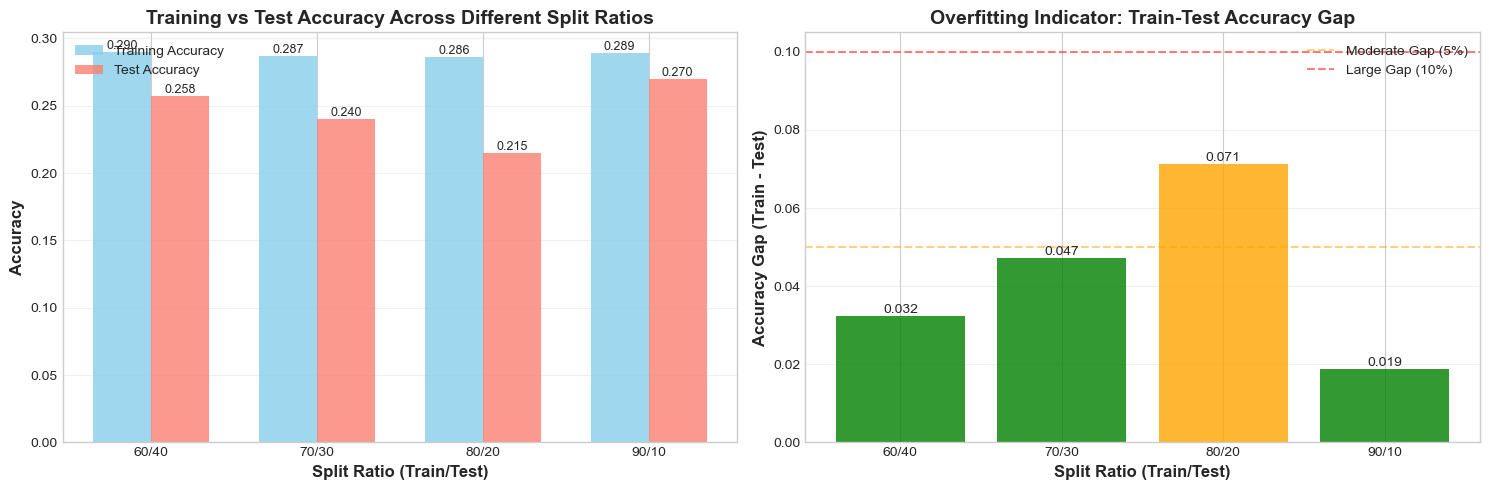


📊 Visualization shows how accuracy changes with different split ratios


In [8]:
# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Train vs Test Accuracy
ax1 = axes[0]
x_pos = np.arange(len(results_df))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, results_df['train_accuracy'], width, 
                label='Training Accuracy', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x_pos + width/2, results_df['test_accuracy'], width, 
                label='Test Accuracy', alpha=0.8, color='salmon')

ax1.set_xlabel('Split Ratio (Train/Test)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Training vs Test Accuracy Across Different Split Ratios', 
              fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['split_ratio'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Accuracy Gap (Overfitting Indicator)
ax2 = axes[1]
accuracy_gap = results_df['train_accuracy'] - results_df['test_accuracy']
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.10 else 'red' for gap in accuracy_gap]

bars3 = ax2.bar(results_df['split_ratio'], accuracy_gap, alpha=0.8, color=colors)
ax2.set_xlabel('Split Ratio (Train/Test)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy Gap (Train - Test)', fontsize=12, fontweight='bold')
ax2.set_title('Overfitting Indicator: Train-Test Accuracy Gap', 
              fontsize=14, fontweight='bold')
ax2.axhline(y=0.05, color='orange', linestyle='--', label='Moderate Gap (5%)', alpha=0.5)
ax2.axhline(y=0.10, color='red', linestyle='--', label='Large Gap (10%)', alpha=0.5)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n📊 Visualization shows how accuracy changes with different split ratios")

### 1.3 Analyze the bias-variance tradeoff

The **bias-variance tradeoff** is a fundamental concept in machine learning:

- **High Bias (Underfitting):** Model is too simple, performs poorly on both training and test data
- **High Variance (Overfitting):** Model is too complex, performs well on training but poorly on test data
- **Balanced:** Model generalizes well, similar performance on both training and test data

The train-test split ratio affects this tradeoff. Let's analyze our results to identify the optimal balance.

In [9]:
print("=" * 70)
print("BIAS-VARIANCE TRADEOFF ANALYSIS")
print("=" * 70)

for idx, row in results_df.iterrows():
    split = row['split_ratio']
    train_acc = row['train_accuracy']
    test_acc = row['test_accuracy']
    gap = train_acc - test_acc
    
    print(f"\n{split} Split:")
    print(f"  Training Samples: {row['train_size']}")
    print(f"  Test Samples: {row['test_size']}")
    print(f"  Accuracy Gap: {gap:.4f}")
    
    # Analysis
    if gap < 0.02:
        print(f"  📌 Interpretation: Well-balanced (low variance, reasonable bias)")
    elif gap < 0.05:
        print(f"  📌 Interpretation: Good balance (slight overfitting)")
    elif gap < 0.10:
        print(f"  ⚠️  Interpretation: Moderate overfitting (higher variance)")
    else:
        print(f"  🔴 Interpretation: High overfitting (high variance, low bias)")
    
    # Training set size impact
    if row['train_size'] < 700:
        print(f"  ⚠️  Small training set may lead to higher variance")
    elif row['test_size'] < 100:
        print(f"  ⚠️  Small test set may give unreliable performance estimates")

print("\n" + "=" * 70)
print("\nKEY OBSERVATIONS:")
print("=" * 70)

# Find best split
best_idx = results_df['test_accuracy'].idxmax()
best_split = results_df.loc[best_idx, 'split_ratio']
best_test_acc = results_df.loc[best_idx, 'test_accuracy']

print(f"\n1. 📈 Best Test Accuracy: {best_test_acc:.4f} achieved with {best_split} split")

# Find most balanced
results_df['balance_score'] = results_df['test_accuracy'] - abs(results_df['train_accuracy'] - results_df['test_accuracy'])
most_balanced_idx = results_df['balance_score'].idxmax()
balanced_split = results_df.loc[most_balanced_idx, 'split_ratio']

print(f"\n2. ⚖️  Most Balanced Split: {balanced_split}")
print(f"   - Minimizes overfitting while maintaining good performance")

print(f"\n3. 🔍 General Pattern:")
print(f"   - As training size ↑: Model has more data to learn patterns")
print(f"   - As test size ↓: Less reliable evaluation, but more training data")
print(f"   - Trade-off: Need enough training data to learn, enough test data to validate")

print(f"\n4. 💡 Recommendation:")
if best_split == '80/20':
    print(f"   - 80/20 split is the standard choice for good reason!")
    print(f"   - Provides sufficient training data while keeping enough for validation")
elif best_split == '70/30':
    print(f"   - 70/30 split provides more robust testing")
    print(f"   - Good when dataset is smaller or we need reliable evaluation")
else:
    print(f"   - Consider dataset size and problem complexity")
    print(f"   - Larger datasets can afford smaller test sets (90/10)")
    print(f"   - Smaller datasets need more conservative splits (70/30 or 60/40)")

BIAS-VARIANCE TRADEOFF ANALYSIS

60/40 Split:
  Training Samples: 600
  Test Samples: 400
  Accuracy Gap: 0.0325
  📌 Interpretation: Good balance (slight overfitting)
  ⚠️  Small training set may lead to higher variance

70/30 Split:
  Training Samples: 700
  Test Samples: 300
  Accuracy Gap: 0.0471
  📌 Interpretation: Good balance (slight overfitting)

80/20 Split:
  Training Samples: 800
  Test Samples: 200
  Accuracy Gap: 0.0713
  ⚠️  Interpretation: Moderate overfitting (higher variance)

90/10 Split:
  Training Samples: 900
  Test Samples: 100
  Accuracy Gap: 0.0189
  📌 Interpretation: Well-balanced (low variance, reasonable bias)


KEY OBSERVATIONS:

1. 📈 Best Test Accuracy: 0.2700 achieved with 90/10 split

2. ⚖️  Most Balanced Split: 90/10
   - Minimizes overfitting while maintaining good performance

3. 🔍 General Pattern:
   - As training size ↑: Model has more data to learn patterns
   - As test size ↓: Less reliable evaluation, but more training data
   - Trade-off: Need eno

---
# 2. Stratified Splitting

## Handling Imbalanced Classification Problems

In many real-world datasets, classes are not equally represented. For example:
- Fraud detection: 99% legitimate, 1% fraudulent transactions
- Medical diagnosis: 95% healthy, 5% disease cases
- Customer churn: 80% retained, 20% churned

**The Problem with Regular Splitting:**
When you randomly split an imbalanced dataset, you might end up with:
- A test set missing some minority classes entirely
- Unrepresentative class distributions in train/test sets
- Unreliable performance metrics
- Models that fail to learn minority classes

**The Solution: Stratified Splitting**
Stratified splitting ensures that both training and test sets maintain the same class proportions as the original dataset. This is especially critical for imbalanced datasets where minority classes need representation in both sets.

In this section, we'll:
1. Analyze class distribution in our dataset
2. Compare regular vs stratified splitting
3. Demonstrate the impact on model performance and reliability

### 2.1 Analyze Class Distribution

First, let's examine our dataset to see if we have class imbalance. We'll calculate:
- The number of samples in each class
- The percentage distribution
- The imbalance ratio (ratio of largest to smallest class)

An imbalance ratio greater than 2:1 suggests we should use stratified splitting.

ORIGINAL DATASET CLASS DISTRIBUTION
ICU                 :  241 samples (24.10%)
emergency           :  263 samples (26.30%)
general_medicine    :  242 samples (24.20%)
surgery             :  254 samples (25.40%)

Total samples: 1000


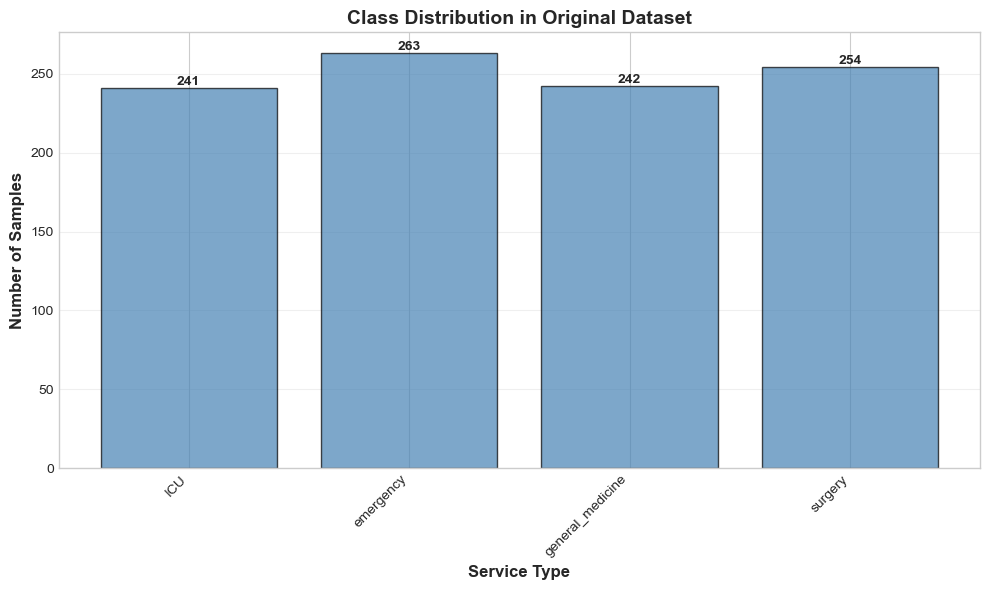


📊 Imbalance Ratio: 1.09:1
✓ Dataset is relatively balanced


In [10]:
# Check class distribution in original dataset
class_counts = pd.Series(y).value_counts().sort_index()
class_labels = le.inverse_transform(class_counts.index)

print("=" * 60)
print("ORIGINAL DATASET CLASS DISTRIBUTION")
print("=" * 60)

for label, count in zip(class_labels, class_counts.values):
    percentage = (count / len(y)) * 100
    print(f"{label:20s}: {count:4d} samples ({percentage:5.2f}%)")

print(f"\nTotal samples: {len(y)}")

# Visualize distribution
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(class_labels, class_counts.values, alpha=0.7, color='steelblue', edgecolor='black')
ax.set_xlabel('Service Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_title('Class Distribution in Original Dataset', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Check if imbalanced
max_class = class_counts.max()
min_class = class_counts.min()
imbalance_ratio = max_class / min_class

print(f"\n📊 Imbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 2:
    print("⚠️  Dataset is IMBALANCED - Stratified splitting is recommended!")
else:
    print("✓ Dataset is relatively balanced")

### 2.2 Compare Regular vs Stratified Splitting

Now we'll perform both types of splits and compare the resulting class distributions. 

**What to look for:**
- How closely do the split distributions match the original?
- Are minority classes properly represented in both train and test sets?
- What is the deviation (in percentage points) from the original distribution?

Smaller deviations indicate better preservation of class proportions.

In [11]:
# Perform REGULAR split (does not preserve class proportions)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Perform STRATIFIED split (preserves class proportions)
# The key parameter is stratify=y, which tells sklearn to maintain class distribution
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("=" * 80)
print("COMPARING REGULAR vs STRATIFIED SPLITTING")
print("=" * 80)

# Function to calculate class distribution
def get_distribution(y_data, label_name):
    """
    Calculate both counts and percentages for each class.
    This helps us see if the split maintains the original proportions.
    """
    counts = pd.Series(y_data).value_counts().sort_index()
    percentages = (counts / len(y_data) * 100).round(2)
    return counts, percentages

# Get distributions for all splits
orig_counts, orig_pct = get_distribution(y, "Original")
reg_train_counts, reg_train_pct = get_distribution(y_train_reg, "Regular Train")
reg_test_counts, reg_test_pct = get_distribution(y_test_reg, "Regular Test")
strat_train_counts, strat_train_pct = get_distribution(y_train_strat, "Stratified Train")
strat_test_counts, strat_test_pct = get_distribution(y_test_strat, "Stratified Test")

# Create comparison dataframe for easy visualization
comparison_df = pd.DataFrame({
    'Class': le.classes_,
    'Original %': orig_pct.values,
    'Regular Train %': reg_train_pct.values,
    'Regular Test %': reg_test_pct.values,
    'Stratified Train %': strat_train_pct.values,
    'Stratified Test %': strat_test_pct.values
})

print("\n📊 CLASS DISTRIBUTION COMPARISON (Percentages):\n")
print(comparison_df.to_string(index=False))
print("\nLook at how stratified columns closely match the original percentages!")

# Calculate deviation from original distribution
print("\n\n📏 DEVIATION FROM ORIGINAL DISTRIBUTION:\n")
print("Lower deviation = better preservation of class proportions\n")

for class_name in le.classes_:
    idx = list(le.classes_).index(class_name)
    orig = orig_pct.iloc[idx]
    
    reg_train_dev = abs(reg_train_pct.iloc[idx] - orig)
    reg_test_dev = abs(reg_test_pct.iloc[idx] - orig)
    strat_train_dev = abs(strat_train_pct.iloc[idx] - orig)
    strat_test_dev = abs(strat_test_pct.iloc[idx] - orig)
    
    print(f"\n{class_name}:")
    print(f"  Regular Split    - Train: ±{reg_train_dev:.2f}%  | Test: ±{reg_test_dev:.2f}%")
    print(f"  Stratified Split - Train: ±{strat_train_dev:.2f}%  | Test: ±{strat_test_dev:.2f}%")
    
    # Highlight which is better
    if strat_train_dev < reg_train_dev and strat_test_dev < reg_test_dev:
        print(f"  ✓ Stratified is better (lower deviation)")

COMPARING REGULAR vs STRATIFIED SPLITTING

📊 CLASS DISTRIBUTION COMPARISON (Percentages):

           Class  Original %  Regular Train %  Regular Test %  Stratified Train %  Stratified Test %
             ICU        24.1            23.50            26.5               24.12               24.0
       emergency        26.3            26.12            27.0               26.25               26.5
general_medicine        24.2            23.88            25.5               24.25               24.0
         surgery        25.4            26.50            21.0               25.37               25.5

Look at how stratified columns closely match the original percentages!


📏 DEVIATION FROM ORIGINAL DISTRIBUTION:

Lower deviation = better preservation of class proportions


ICU:
  Regular Split    - Train: ±0.60%  | Test: ±2.40%
  Stratified Split - Train: ±0.02%  | Test: ±0.10%
  ✓ Stratified is better (lower deviation)

emergency:
  Regular Split    - Train: ±0.18%  | Test: ±0.70%
  Stratified Sp

### 2.3 Visualize Class Distributions in Each Split

Visual comparison makes it easier to spot differences between regular and stratified splitting. We'll create four plots showing:

1. **Regular Split Distribution:** How classes are distributed in train vs test sets
2. **Stratified Split Distribution:** How stratified splitting maintains proportions
3. **Training Set Deviations:** Comparing how far each method deviates from original distribution
4. **Test Set Deviations:** Same comparison for test sets

Lower deviations in stratified splitting demonstrate its superiority for imbalanced data.

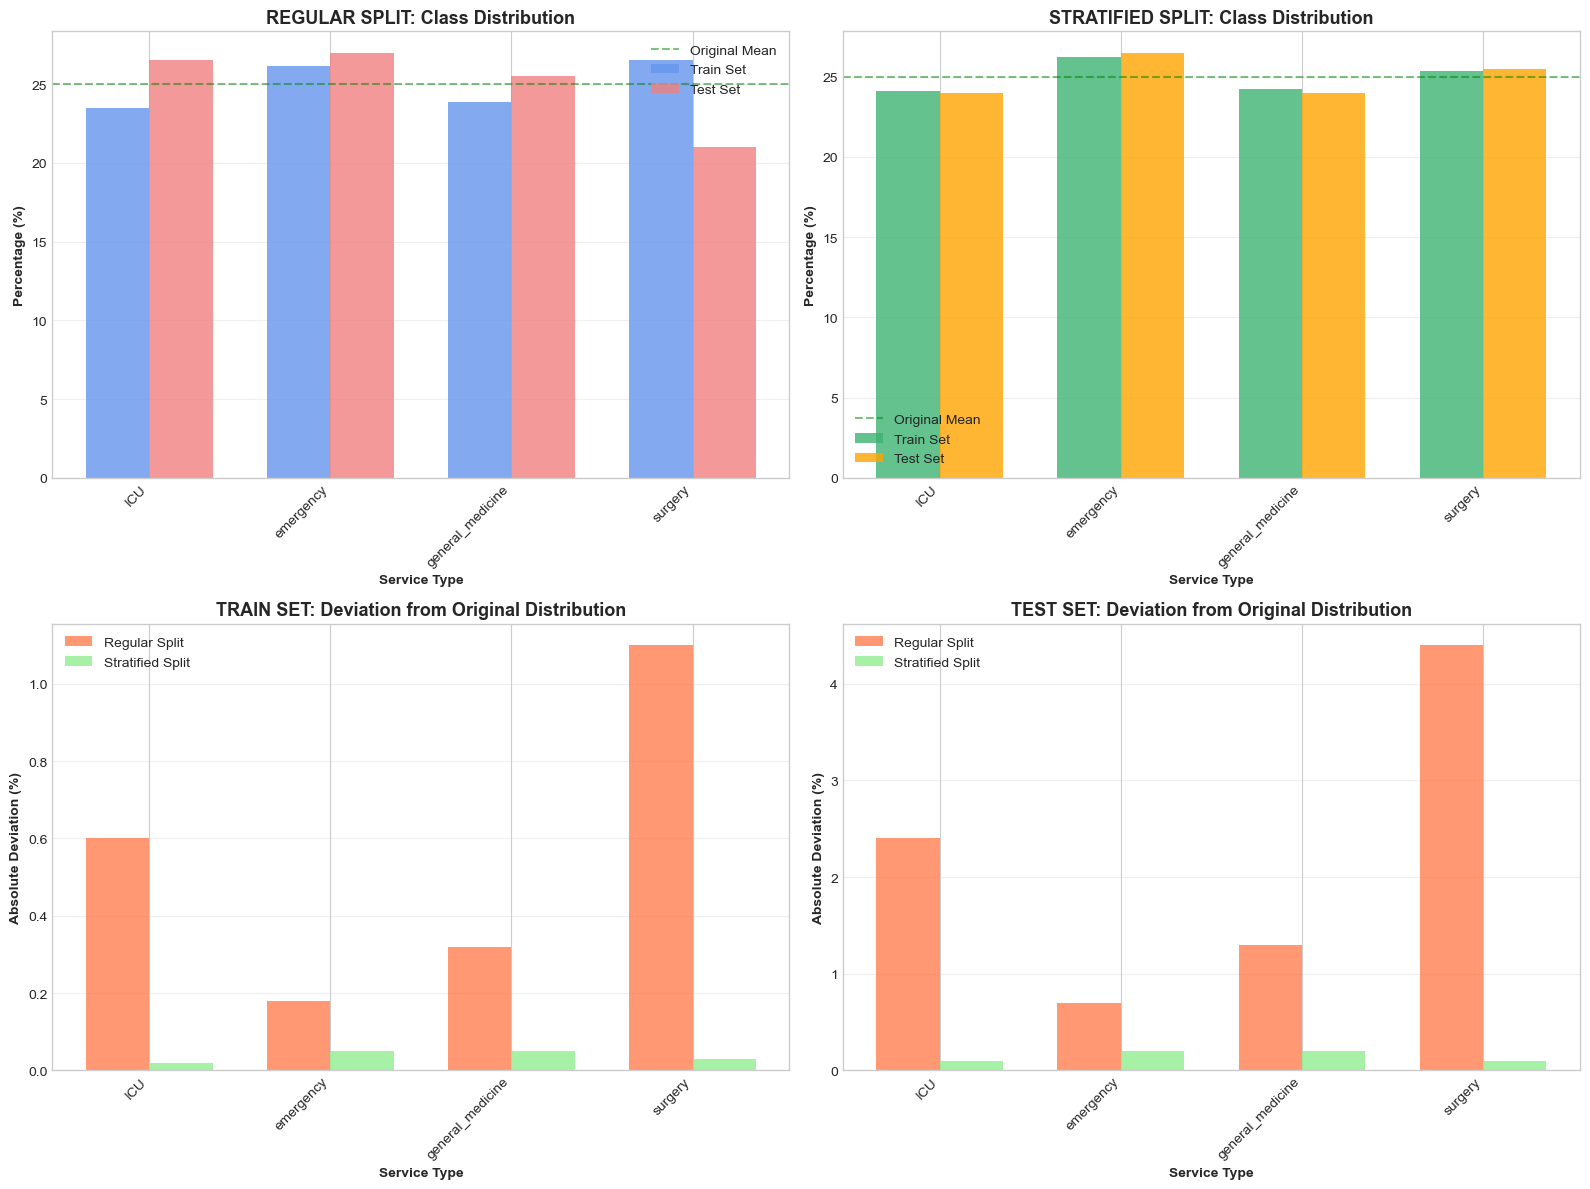


✓ Stratified splitting maintains class proportions better than regular splitting


In [12]:
# Create visualization comparing distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

class_names = le.classes_
x_pos = np.arange(len(class_names))
bar_width = 0.35

# Plot 1: Regular Split - Train vs Test
ax1 = axes[0, 0]
bars1 = ax1.bar(x_pos - bar_width/2, reg_train_pct.values, bar_width, 
                label='Train Set', alpha=0.8, color='cornflowerblue')
bars2 = ax1.bar(x_pos + bar_width/2, reg_test_pct.values, bar_width, 
                label='Test Set', alpha=0.8, color='lightcoral')
ax1.axhline(y=orig_pct.mean(), color='green', linestyle='--', 
            label='Original Mean', alpha=0.5)
ax1.set_xlabel('Service Type', fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontweight='bold')
ax1.set_title('REGULAR SPLIT: Class Distribution', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(class_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Stratified Split - Train vs Test
ax2 = axes[0, 1]
bars3 = ax2.bar(x_pos - bar_width/2, strat_train_pct.values, bar_width, 
                label='Train Set', alpha=0.8, color='mediumseagreen')
bars4 = ax2.bar(x_pos + bar_width/2, strat_test_pct.values, bar_width, 
                label='Test Set', alpha=0.8, color='orange')
ax2.axhline(y=orig_pct.mean(), color='green', linestyle='--', 
            label='Original Mean', alpha=0.5)
ax2.set_xlabel('Service Type', fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontweight='bold')
ax2.set_title('STRATIFIED SPLIT: Class Distribution', fontsize=13, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(class_names, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Deviation comparison for Train sets
ax3 = axes[1, 0]
train_deviations_reg = abs(reg_train_pct.values - orig_pct.values)
train_deviations_strat = abs(strat_train_pct.values - orig_pct.values)

bars5 = ax3.bar(x_pos - bar_width/2, train_deviations_reg, bar_width, 
                label='Regular Split', alpha=0.8, color='coral')
bars6 = ax3.bar(x_pos + bar_width/2, train_deviations_strat, bar_width, 
                label='Stratified Split', alpha=0.8, color='lightgreen')
ax3.set_xlabel('Service Type', fontweight='bold')
ax3.set_ylabel('Absolute Deviation (%)', fontweight='bold')
ax3.set_title('TRAIN SET: Deviation from Original Distribution', 
              fontsize=13, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(class_names, rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Deviation comparison for Test sets
ax4 = axes[1, 1]
test_deviations_reg = abs(reg_test_pct.values - orig_pct.values)
test_deviations_strat = abs(strat_test_pct.values - orig_pct.values)

bars7 = ax4.bar(x_pos - bar_width/2, test_deviations_reg, bar_width, 
                label='Regular Split', alpha=0.8, color='coral')
bars8 = ax4.bar(x_pos + bar_width/2, test_deviations_strat, bar_width, 
                label='Stratified Split', alpha=0.8, color='lightgreen')
ax4.set_xlabel('Service Type', fontweight='bold')
ax4.set_ylabel('Absolute Deviation (%)', fontweight='bold')
ax4.set_title('TEST SET: Deviation from Original Distribution', 
              fontsize=13, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(class_names, rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Stratified splitting maintains class proportions better than regular splitting")

### 2.4 Demonstrate the Impact on Model Performance

Theory is important, but what really matters is: **Does stratified splitting lead to better model performance?**

We'll train two identical logistic regression models:
- One on a regular split
- One on a stratified split

Then we'll compare:
- Overall test accuracy
- Per-class precision, recall, and F1-scores
- Which method provides more reliable and representative evaluation

The classification report will show us if stratified splitting helps the model better learn minority classes.

In [13]:
# Train models on both split types
print("=" * 80)
print("MODEL PERFORMANCE COMPARISON: Regular vs Stratified Splitting")
print("=" * 80)

# Model 1: Regular Split
model_reg = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = model_reg.predict(X_test_reg)
acc_reg = accuracy_score(y_test_reg, y_pred_reg)

print("\n📌 REGULAR SPLIT RESULTS:")
print(f"  Test Accuracy: {acc_reg:.4f}")
print("\n  Classification Report:")
print(classification_report(y_test_reg, y_pred_reg, target_names=le.classes_, zero_division=0))

# Model 2: Stratified Split
model_strat = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model_strat.fit(X_train_strat, y_train_strat)
y_pred_strat = model_strat.predict(X_test_strat)
acc_strat = accuracy_score(y_test_strat, y_pred_strat)

print("\n" + "=" * 80)
print("\n📌 STRATIFIED SPLIT RESULTS:")
print(f"  Test Accuracy: {acc_strat:.4f}")
print("\n  Classification Report:")
print(classification_report(y_test_strat, y_pred_strat, target_names=le.classes_, zero_division=0))

# Compare
print("\n" + "=" * 80)
print("📊 COMPARISON:")
print("=" * 80)
print(f"\nRegular Split Accuracy:     {acc_reg:.4f}")
print(f"Stratified Split Accuracy:  {acc_strat:.4f}")
print(f"Difference:                 {abs(acc_reg - acc_strat):.4f}")

if acc_strat > acc_reg:
    print(f"\n✓ Stratified split performs BETTER by {(acc_strat - acc_reg):.4f}")
elif acc_reg > acc_strat:
    print(f"\n⚠️  Regular split performs better by {(acc_reg - acc_strat):.4f}")
else:
    print(f"\n→ Both methods perform equally")

print("\n💡 KEY INSIGHT:")
print("   Stratified splitting ensures that both train and test sets have")
print("   representative samples from all classes, leading to more reliable")
print("   and generalizable model evaluation, especially for imbalanced datasets.")

MODEL PERFORMANCE COMPARISON: Regular vs Stratified Splitting

📌 REGULAR SPLIT RESULTS:
  Test Accuracy: 0.2150

  Classification Report:
                  precision    recall  f1-score   support

             ICU       0.19      0.09      0.13        53
       emergency       0.26      0.19      0.22        54
general_medicine       0.21      0.24      0.22        51
         surgery       0.20      0.38      0.26        42

        accuracy                           0.21       200
       macro avg       0.22      0.22      0.21       200
    weighted avg       0.22      0.21      0.20       200



📌 STRATIFIED SPLIT RESULTS:
  Test Accuracy: 0.2200

  Classification Report:
                  precision    recall  f1-score   support

             ICU       0.36      0.10      0.16        48
       emergency       0.16      0.17      0.17        53
general_medicine       0.23      0.33      0.27        48
         surgery       0.23      0.27      0.25        51

        accuracy       

---
# 3. Time-Series Splitting

## Respecting the Flow of Time

Time-series data has a special property: **temporal ordering matters**. Events unfold sequentially, and future events cannot influence the past. This fundamental principle must be respected in our train-test splitting strategy.

**The Critical Problem: Data Leakage**

Imagine you're building a model to predict stock prices. If you randomly split your data:
- Your training set might include stock prices from December 2024
- Your test set might include prices from January 2024
- You're essentially using "future" data to predict the "past"
- When deployed in the real world (where you can only use historical data), your model will perform much worse

This is called **data leakage** or **temporal leakage**, and it's one of the most common mistakes in time-series modeling.

**The Correct Approach: Temporal Splitting**

For time-series data, we must:
1. ✓ Sort data by time
2. ✓ Split at a specific point in time
3. ✓ Train ONLY on past data
4. ✓ Test ONLY on future data
5. ✓ Never shuffle or use random splits

In this section, we'll:
- Demonstrate why random splitting fails for time-series
- Implement proper temporal splitting
- Use walk-forward validation to simulate real-world deployment

### 3.1 Prepare Time-Series Dataset

Our patient dataset has a natural temporal ordering based on arrival dates. We'll:
- Verify the data is sorted by time
- Examine the temporal distribution
- Visualize how patient arrivals and service types change over time

This exploration helps us understand if there are any temporal patterns or trends that our model might need to account for.

TIME-SERIES DATASET PREPARATION

Dataset date range:
  First arrival:  2025-01-02 00:00:00
  Last arrival:   2025-12-31 00:00:00
  Time span:      363 days

✓ Dataset is sorted by arrival_date: True


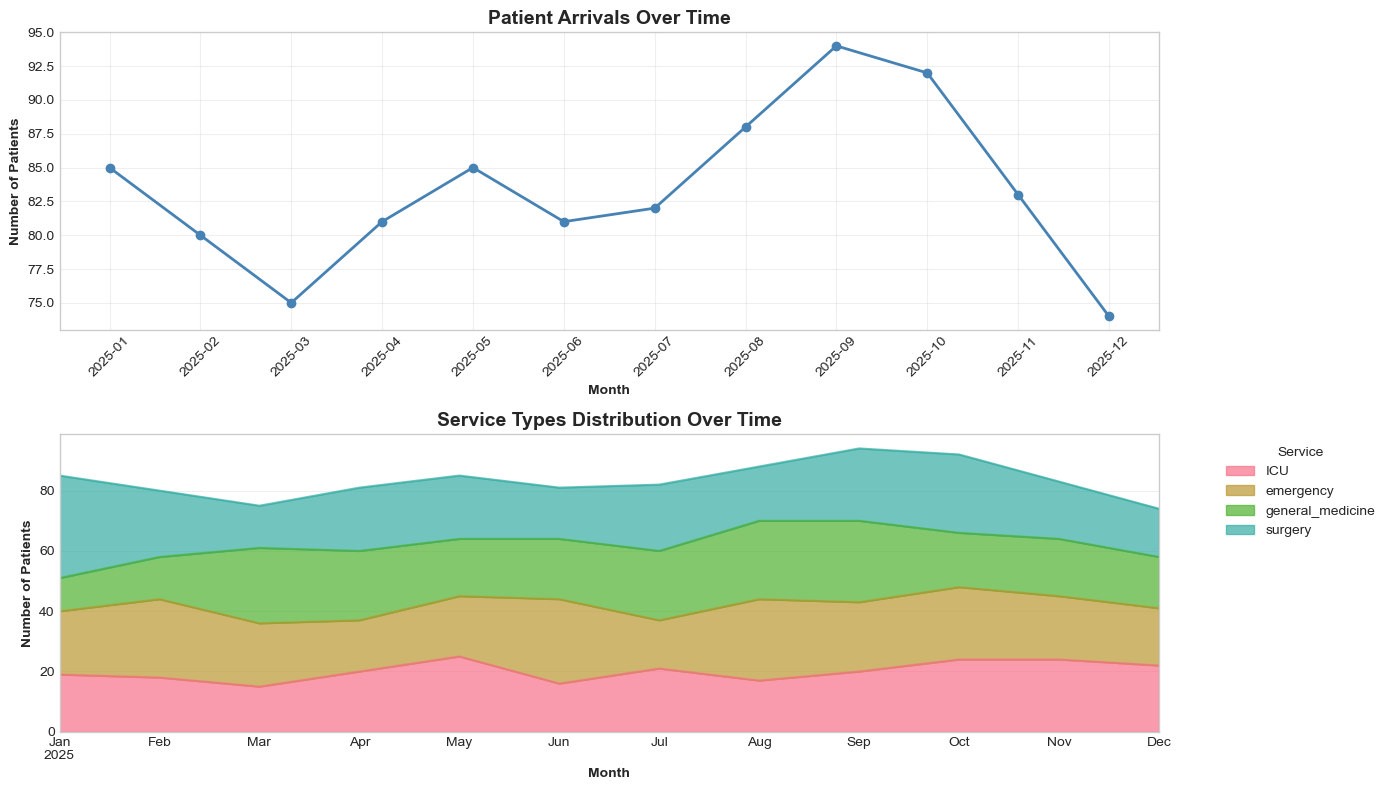


📊 Time-series characteristics observed in the data


In [14]:
# Our dataset already has temporal ordering (arrival_date)
# Let's verify it's sorted by time
print("=" * 80)
print("TIME-SERIES DATASET PREPARATION")
print("=" * 80)

print(f"\nDataset date range:")
print(f"  First arrival:  {df['arrival_date'].min()}")
print(f"  Last arrival:   {df['arrival_date'].max()}")
print(f"  Time span:      {(df['arrival_date'].max() - df['arrival_date'].min()).days} days")

# Verify temporal ordering
print(f"\n✓ Dataset is sorted by arrival_date: {df['arrival_date'].is_monotonic_increasing}")

# Visualize temporal distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Arrivals over time
ax1 = axes[0]
df['arrival_month_year'] = df['arrival_date'].dt.to_period('M')
monthly_counts = df.groupby('arrival_month_year').size()
ax1.plot(monthly_counts.index.astype(str), monthly_counts.values, 
         marker='o', linewidth=2, markersize=6, color='steelblue')
ax1.set_xlabel('Month', fontweight='bold')
ax1.set_ylabel('Number of Patients', fontweight='bold')
ax1.set_title('Patient Arrivals Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Service type over time
ax2 = axes[1]
service_over_time = df.groupby(['arrival_month_year', 'service']).size().unstack(fill_value=0)
service_over_time.plot(kind='area', stacked=True, ax=ax2, alpha=0.7)
ax2.set_xlabel('Month', fontweight='bold')
ax2.set_ylabel('Number of Patients', fontweight='bold')
ax2.set_title('Service Types Distribution Over Time', fontsize=14, fontweight='bold')
ax2.legend(title='Service', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Time-series characteristics observed in the data")

### 3.2 Explain Why Random Splitting is Problematic for Time-Series Data

This is perhaps the most important concept in time-series machine learning. Let's break down exactly why random splitting causes catastrophic problems:

**The Fundamental Issue: Causality Violation**

In the real world, time flows in one direction: Past → Present → Future

But random splitting creates an impossible scenario where:
- Training data contains samples from ALL time periods
- Test data also contains samples from ALL time periods
- The model learns from "future" information to predict "past" events
- This violates the fundamental principle of causality

**Why This Matters in Production**

When you deploy your model:
- It only has access to historical data (the past)
- It must predict future events
- But during training, it learned patterns from future data
- Those patterns won't be available in production
- Result: Dramatic performance drop

We'll demonstrate this with a concrete example, showing how random and temporal splits produce different date ranges and different performance metrics.

In [15]:
print("=" * 80)
print("WHY RANDOM SPLITTING FAILS FOR TIME-SERIES DATA")
print("=" * 80)

print("\n🚫 PROBLEM: DATA LEAKAGE - Training on Future Data")
print("-" * 80)

print("""
When we use RANDOM splitting on time-series data, we create a critical problem:

1. ⚠️  TEMPORAL INFORMATION LEAKAGE:
   - Random split mixes past, present, and future data
   - Training set may contain samples from AFTER the test set
   - Model learns from "future" information to predict "past" events
   - This is UNREALISTIC - in production, we can't use future data!

2. 📈 OVERLY OPTIMISTIC PERFORMANCE:
   - Model appears to perform better than it actually would
   - Test accuracy is artificially inflated
   - Creates false confidence in model quality

3. 🔮 FAILS IN PRODUCTION:
   - When deployed, model only has access to historical data
   - Cannot use future patterns it learned during training
   - Real-world performance is much worse than expected

4. 🔄 IGNORES TEMPORAL PATTERNS:
   - Time-series data often has trends, seasonality, concept drift
   - Random splitting breaks temporal dependencies
   - Model can't learn proper sequential patterns

5. ❌ VIOLATES CAUSALITY:
   - In real-world: Past → Present → Future
   - Random split: Future → Past (impossible!)
   - Breaks fundamental assumption of time
""")

print("\n" + "=" * 80)
print("DEMONSTRATION: Random vs Temporal Split")
print("=" * 80)

# Random split (WRONG for time-series)
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Get indices to see temporal distribution
train_indices_random = X_train_random.index
test_indices_random = X_test_random.index

train_dates_random = df.loc[train_indices_random, 'arrival_date']
test_dates_random = df.loc[test_indices_random, 'arrival_date']

print(f"\n📅 RANDOM SPLIT (Problematic):")
print(f"  Train set date range: {train_dates_random.min()} to {train_dates_random.max()}")
print(f"  Test set date range:  {test_dates_random.min()} to {test_dates_random.max()}")
print(f"  ⚠️  OVERLAP: {(train_dates_random.max() > test_dates_random.min())}")

# Temporal split (CORRECT for time-series)
split_idx = int(len(df) * 0.8)
train_indices_temporal = df.index[:split_idx]
test_indices_temporal = df.index[split_idx:]

X_train_temporal = X.iloc[:split_idx]
X_test_temporal = X.iloc[split_idx:]
y_train_temporal = y[:split_idx]
y_test_temporal = y[split_idx:]

train_dates_temporal = df.loc[train_indices_temporal, 'arrival_date']
test_dates_temporal = df.loc[test_indices_temporal, 'arrival_date']

print(f"\n📅 TEMPORAL SPLIT (Correct):")
print(f"  Train set date range: {train_dates_temporal.min()} to {train_dates_temporal.max()}")
print(f"  Test set date range:  {test_dates_temporal.min()} to {test_dates_temporal.max()}")
print(f"  ✓ NO OVERLAP: {(train_dates_temporal.max() <= test_dates_temporal.min())}")
print(f"  ✓ Train data is ALL before test data")

print("\n💡 KEY PRINCIPLE:")
print("   For time-series: ALWAYS split by time, NEVER randomly!")
print("   Rule: Train on PAST → Test on FUTURE")

WHY RANDOM SPLITTING FAILS FOR TIME-SERIES DATA

🚫 PROBLEM: DATA LEAKAGE - Training on Future Data
--------------------------------------------------------------------------------

When we use RANDOM splitting on time-series data, we create a critical problem:

1. ⚠️  TEMPORAL INFORMATION LEAKAGE:
   - Random split mixes past, present, and future data
   - Training set may contain samples from AFTER the test set
   - Model learns from "future" information to predict "past" events
   - This is UNREALISTIC - in production, we can't use future data!

2. 📈 OVERLY OPTIMISTIC PERFORMANCE:
   - Model appears to perform better than it actually would
   - Test accuracy is artificially inflated
   - Creates false confidence in model quality

3. 🔮 FAILS IN PRODUCTION:
   - When deployed, model only has access to historical data
   - Cannot use future patterns it learned during training
   - Real-world performance is much worse than expected

4. 🔄 IGNORES TEMPORAL PATTERNS:
   - Time-series data o

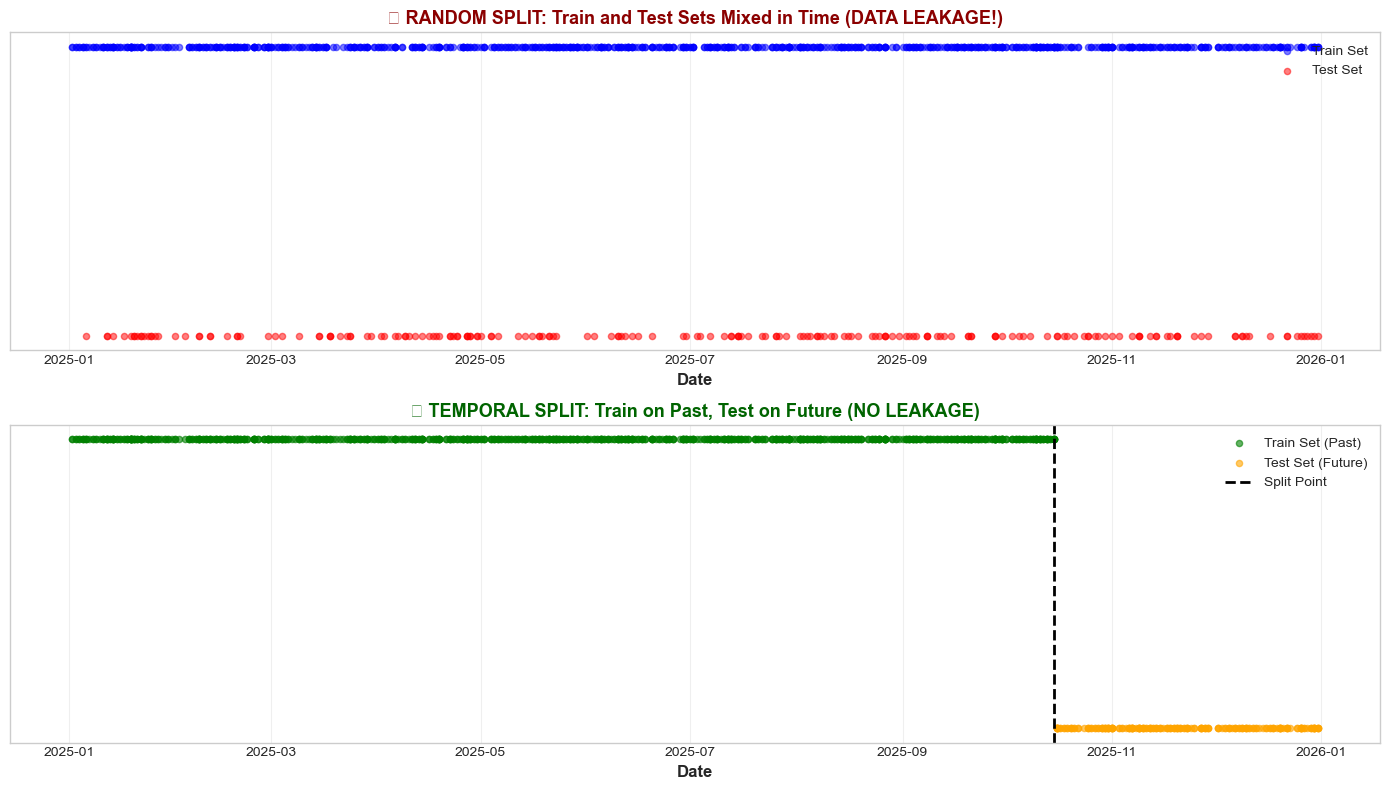


📊 Visualization clearly shows the difference:
   • Random split: Data points from all time periods mixed together
   • Temporal split: Clean separation - all training data before test data


In [16]:
# Visualize the difference
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Random Split Visualization
ax1 = axes[0]
timeline = df['arrival_date'].values
train_mask_random = np.isin(df.index, train_indices_random)
test_mask_random = np.isin(df.index, test_indices_random)

ax1.scatter(df.loc[train_mask_random, 'arrival_date'], 
           np.ones(train_mask_random.sum()), 
           c='blue', alpha=0.5, s=20, label='Train Set')
ax1.scatter(df.loc[test_mask_random, 'arrival_date'], 
           np.ones(test_mask_random.sum()) * 0.95, 
           c='red', alpha=0.5, s=20, label='Test Set')
ax1.set_yticks([])
ax1.set_xlabel('Date', fontweight='bold', fontsize=12)
ax1.set_title('❌ RANDOM SPLIT: Train and Test Sets Mixed in Time (DATA LEAKAGE!)', 
              fontsize=13, fontweight='bold', color='darkred')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Temporal Split Visualization
ax2 = axes[1]
ax2.scatter(df.loc[train_indices_temporal, 'arrival_date'], 
           np.ones(len(train_indices_temporal)), 
           c='green', alpha=0.6, s=20, label='Train Set (Past)')
ax2.scatter(df.loc[test_indices_temporal, 'arrival_date'], 
           np.ones(len(test_indices_temporal)) * 0.95, 
           c='orange', alpha=0.6, s=20, label='Test Set (Future)')
ax2.axvline(x=train_dates_temporal.max(), color='black', linestyle='--', 
           linewidth=2, label='Split Point')
ax2.set_yticks([])
ax2.set_xlabel('Date', fontweight='bold', fontsize=12)
ax2.set_title('✓ TEMPORAL SPLIT: Train on Past, Test on Future (NO LEAKAGE)', 
              fontsize=13, fontweight='bold', color='darkgreen')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 Visualization clearly shows the difference:")
print("   • Random split: Data points from all time periods mixed together")
print("   • Temporal split: Clean separation - all training data before test data")

### 3.3 Implement Proper Temporal Splitting (No Future Data in Training)

Now we'll implement the correct approach for time-series data:

**The Temporal Split Strategy:**
1. Sort data by timestamp (already done)
2. Choose a split point in time (e.g., 80% through the timeline)
3. Everything BEFORE that point → Training set
4. Everything AFTER that point → Test set
5. Verify there's NO temporal overlap

This ensures:
- ✓ Training data is strictly in the past
- ✓ Test data is strictly in the future
- ✓ No data leakage
- ✓ Realistic performance estimates

We'll compare this with random splitting to show the difference in both approach and results.

In [17]:
# Implement proper temporal split
print("=" * 80)
print("PROPER TEMPORAL SPLITTING IMPLEMENTATION")
print("=" * 80)

# Method 1: Simple train-test temporal split (80/20)
split_point = int(len(df) * 0.8)
split_date = df.iloc[split_point]['arrival_date']

print(f"\n📍 Split Configuration:")
print(f"  Training period: {df['arrival_date'].min()} to {df.iloc[split_point-1]['arrival_date']}")
print(f"  Test period:     {split_date} to {df['arrival_date'].max()}")
print(f"  Training samples: {split_point} ({split_point/len(df)*100:.1f}%)")
print(f"  Test samples:     {len(df)-split_point} ({(len(df)-split_point)/len(df)*100:.1f}%)")

# Train and evaluate
model_temporal = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model_temporal.fit(X_train_temporal, y_train_temporal)

y_pred_temporal = model_temporal.predict(X_test_temporal)
acc_temporal = accuracy_score(y_test_temporal, y_pred_temporal)

print(f"\n📊 Temporal Split Model Performance:")
print(f"  Test Accuracy: {acc_temporal:.4f}")

# Compare with random split (to show the difference)
model_random = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model_random.fit(X_train_random, y_train_random)

y_pred_random = model_random.predict(X_test_random)
acc_random = accuracy_score(y_test_random, y_pred_random)

print(f"\n⚠️  Random Split Model Performance (for comparison):")
print(f"  Test Accuracy: {acc_random:.4f}")

print(f"\n📉 Accuracy Difference: {abs(acc_temporal - acc_random):.4f}")

if acc_random > acc_temporal:
    print(f"\n⚠️  Random split shows HIGHER accuracy (by {acc_random - acc_temporal:.4f})")
    print("    This is the DATA LEAKAGE problem!")
    print("    Random split performance is UNREALISTIC and MISLEADING")
else:
    print(f"\n✓ Temporal split provides realistic performance estimate")

print("\n💡 CORRECT APPROACH FOR TIME-SERIES:")
print("   1. Sort data by time")
print("   2. Split at a specific point in time")
print("   3. Train ONLY on past data")
print("   4. Test ONLY on future data")
print("   5. Never shuffle time-series data!")

PROPER TEMPORAL SPLITTING IMPLEMENTATION

📍 Split Configuration:
  Training period: 2025-01-02 00:00:00 to 2025-10-15 00:00:00
  Test period:     2025-10-16 00:00:00 to 2025-12-31 00:00:00
  Training samples: 800 (80.0%)
  Test samples:     200 (20.0%)

📊 Temporal Split Model Performance:
  Test Accuracy: 0.2050

⚠️  Random Split Model Performance (for comparison):
  Test Accuracy: 0.2150

📉 Accuracy Difference: 0.0100

⚠️  Random split shows HIGHER accuracy (by 0.0100)
    This is the DATA LEAKAGE problem!
    Random split performance is UNREALISTIC and MISLEADING

💡 CORRECT APPROACH FOR TIME-SERIES:
   1. Sort data by time
   2. Split at a specific point in time
   3. Train ONLY on past data
   4. Test ONLY on future data
   5. Never shuffle time-series data!


### 3.4 Implement Walk-Forward Validation Approach

**Going Beyond Simple Train-Test Split**

While a single temporal split is correct, it only tests our model on ONE future period. What if:
- That particular period was unusual?
- Model performance varies over time?
- There's concept drift (patterns change over time)?

**Walk-Forward Validation (Time Series Cross-Validation)**

This advanced technique simulates how a model would be deployed and updated over time:

**How It Works:**
1. Start with an initial training window (e.g., first 20% of data)
2. Test on the next time period (e.g., next 10% of data)
3. Expand the training window to include what we just tested
4. Test on the next period
5. Repeat until we've covered all the data

**Why It's Better:**
- ✓ Tests on multiple future periods, not just one
- ✓ Mimics real-world model updates
- ✓ Reveals if model performance is stable over time
- ✓ Detects concept drift or seasonal patterns
- ✓ Provides more robust performance estimates

**The Expanding Window Approach:**
Each fold uses MORE training data than the previous one, just like in production where we continuously collect more historical data.

We'll use scikit-learn's `TimeSeriesSplit` to implement this and analyze performance across all folds.

In [18]:
print("=" * 80)
print("WALK-FORWARD VALIDATION (Time Series Cross-Validation)")
print("=" * 80)

print("""
Walk-forward validation simulates real-world deployment where:
  1. You start with initial historical data
  2. You make predictions on the next time period
  3. You add that period to your training data (model "learns" from it)
  4. You predict the next period
  5. Repeat...

This is EXACTLY how a model would be deployed and updated in production!

EXAMPLE SCENARIO:
  • Fold 1: Train on Jan-Feb, test on Mar
  • Fold 2: Train on Jan-Mar, test on Apr (added March data)
  • Fold 3: Train on Jan-Apr, test on May (added April data)
  • And so on...
  
This approach:
  ✓ Respects temporal order (no data leakage)
  ✓ No future information used for training
  ✓ Tests model on multiple future periods (more robust)
  ✓ Mimics production scenario (expanding knowledge)
  ✓ Reveals performance stability over time
""")

# Use TimeSeriesSplit from sklearn
# n_splits determines how many test periods we'll have
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

print(f"\n🔄 Performing {n_splits}-fold Time Series Cross-Validation")
print("   Each fold trains on an expanding window and tests on the next period")
print("=" * 80)

fold_results = []

for fold_num, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    # Split data for this fold
    X_train_cv = X.iloc[train_idx]
    X_test_cv = X.iloc[test_idx]
    y_train_cv = y[train_idx]
    y_test_cv = y[test_idx]
    
    # Get date ranges to understand what time periods we're using
    train_dates = df.iloc[train_idx]['arrival_date']
    test_dates = df.iloc[test_idx]['arrival_date']
    
    # Train model on historical data
    model_cv = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    model_cv.fit(X_train_cv, y_train_cv)
    
    # Predict on future data
    y_pred_cv = model_cv.predict(X_test_cv)
    acc_cv = accuracy_score(y_test_cv, y_pred_cv)
    
    # Store results for analysis
    fold_results.append({
        'fold': fold_num,
        'train_size': len(train_idx),
        'test_size': len(test_idx),
        'train_start': train_dates.min(),
        'train_end': train_dates.max(),
        'test_start': test_dates.min(),
        'test_end': test_dates.max(),
        'accuracy': acc_cv
    })
    
    print(f"\nFold {fold_num}:")
    print(f"  Train: {train_dates.min().date()} to {train_dates.max().date()} ({len(train_idx)} samples)")
    print(f"  Test:  {test_dates.min().date()} to {test_dates.max().date()} ({len(test_idx)} samples)")
    print(f"  Accuracy: {acc_cv:.4f}")
    print(f"  Note: Training window EXPANDED by {len(test_idx)} samples from previous fold")

# Summary statistics across all folds
fold_results_df = pd.DataFrame(fold_results)
mean_acc = fold_results_df['accuracy'].mean()
std_acc = fold_results_df['accuracy'].std()

print("\n" + "=" * 80)
print("WALK-FORWARD VALIDATION SUMMARY")
print("=" * 80)
print(f"\nPerformance across {n_splits} future time periods:")
print(f"  Mean Accuracy:    {mean_acc:.4f}  ← Overall expected performance")
print(f"  Std Deviation:    {std_acc:.4f}  ← Performance stability")
print(f"  Min Accuracy:     {fold_results_df['accuracy'].min():.4f}  ← Worst case")
print(f"  Max Accuracy:     {fold_results_df['accuracy'].max():.4f}  ← Best case")
print(f"  Accuracy Range:   {fold_results_df['accuracy'].max() - fold_results_df['accuracy'].min():.4f}  ← Variability")

print(f"\n💡 INTERPRETATION:")
if std_acc < 0.05:
    print("   ✓ Low variance across folds (std < 0.05)")
    print("     → Model is STABLE over time")
    print("     → Consistent performance on different time periods")
    print("     → Good sign for production deployment!")
elif std_acc < 0.10:
    print("   → Moderate variance (0.05 < std < 0.10)")
    print("     → Some temporal patterns affecting performance")
    print("     → Monitor for seasonal effects or trends")
    print("     → Consider adding time-based features")
else:
    print("   ⚠️  High variance (std > 0.10)")
    print("     → Significant temporal changes in data distribution")
    print("     → Possible concept drift: patterns changing over time")
    print("     → May need to retrain model frequently")
    print("     → Consider online learning approaches")

print(f"\n📈 RECOMMENDATION:")
print(f"   Use the MEAN accuracy ({mean_acc:.4f}) as your expected performance")
print(f"   Use the STD ({std_acc:.4f}) to set confidence intervals")
print(f"   In production, expect accuracy between {mean_acc - std_acc:.4f} and {mean_acc + std_acc:.4f}")

WALK-FORWARD VALIDATION (Time Series Cross-Validation)

Walk-forward validation simulates real-world deployment where:
  1. You start with initial historical data
  2. You make predictions on the next time period
  3. You add that period to your training data (model "learns" from it)
  4. You predict the next period
  5. Repeat...

This is EXACTLY how a model would be deployed and updated in production!

EXAMPLE SCENARIO:
  • Fold 1: Train on Jan-Feb, test on Mar
  • Fold 2: Train on Jan-Mar, test on Apr (added March data)
  • Fold 3: Train on Jan-Apr, test on May (added April data)
  • And so on...

This approach:
  ✓ Respects temporal order (no data leakage)
  ✓ No future information used for training
  ✓ Tests model on multiple future periods (more robust)
  ✓ Mimics production scenario (expanding knowledge)
  ✓ Reveals performance stability over time


🔄 Performing 5-fold Time Series Cross-Validation
   Each fold trains on an expanding window and tests on the next period

Fold 1:
 

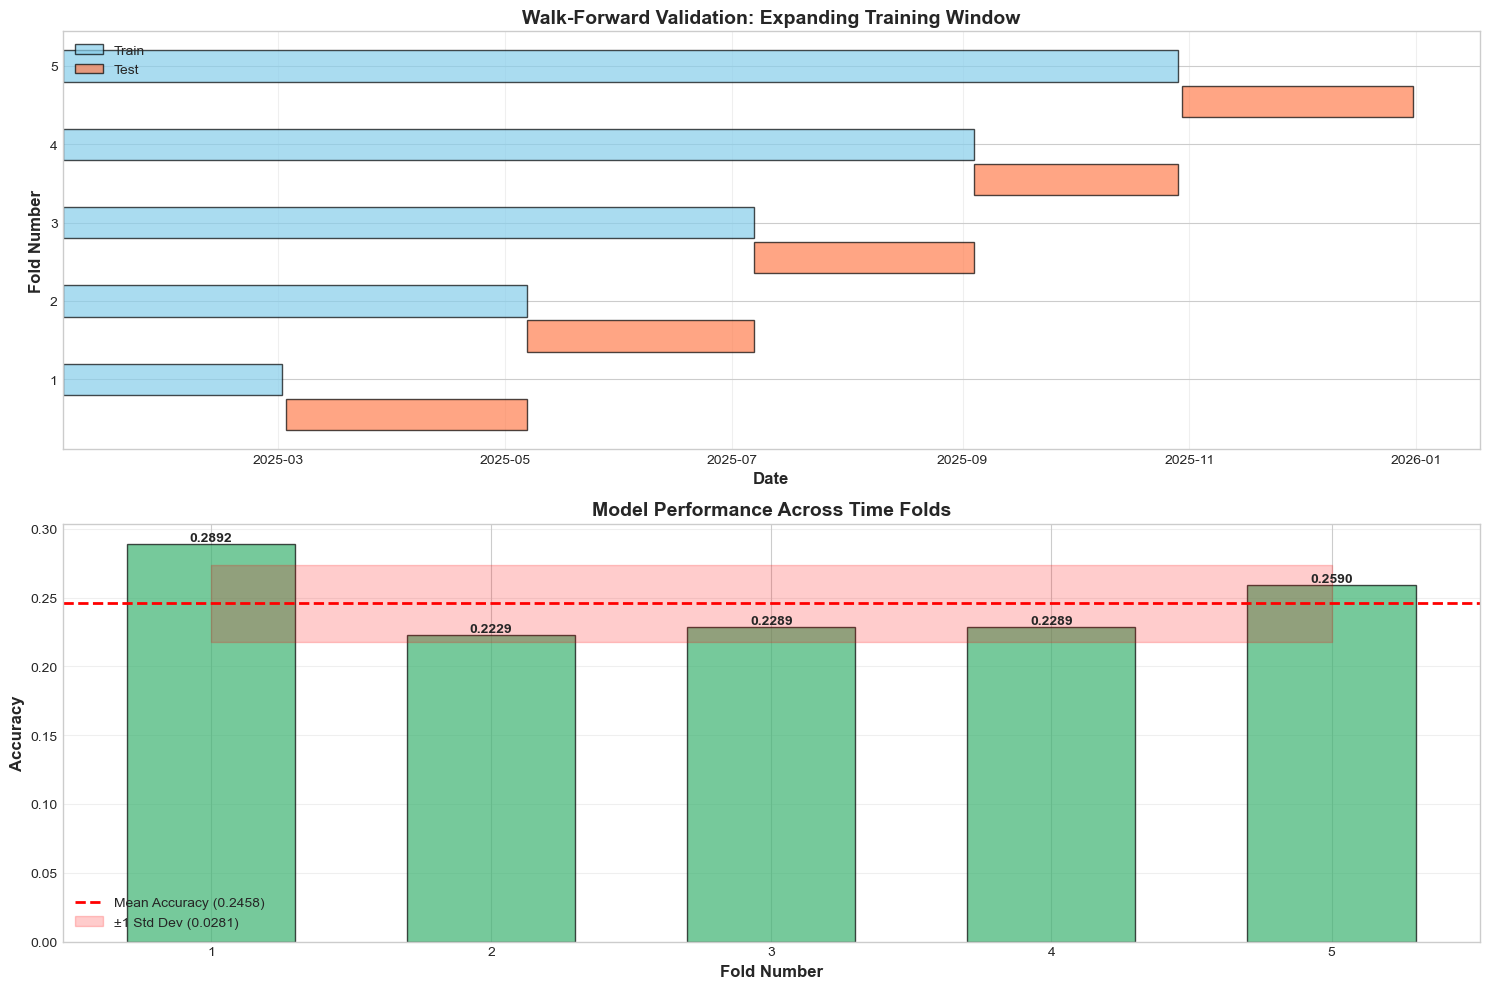


✓ Walk-forward validation complete!
  This approach provides the most realistic performance estimate for time-series data.


In [19]:
# Visualize walk-forward validation
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Training and Test windows for each fold
ax1 = axes[0]
for idx, fold in fold_results_df.iterrows():
    # Train period
    ax1.barh(fold['fold'], 
             (fold['train_end'] - fold['train_start']).days,
             left=fold['train_start'],
             height=0.4,
             alpha=0.7,
             color='skyblue',
             edgecolor='black',
             label='Train' if idx == 0 else '')
    
    # Test period
    ax1.barh(fold['fold'] - 0.45, 
             (fold['test_end'] - fold['test_start']).days,
             left=fold['test_start'],
             height=0.4,
             alpha=0.7,
             color='coral',
             edgecolor='black',
             label='Test' if idx == 0 else '')

ax1.set_xlabel('Date', fontweight='bold', fontsize=12)
ax1.set_ylabel('Fold Number', fontweight='bold', fontsize=12)
ax1.set_title('Walk-Forward Validation: Expanding Training Window', 
              fontsize=14, fontweight='bold')
ax1.set_yticks(fold_results_df['fold'])
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Accuracy across folds
ax2 = axes[1]
bars = ax2.bar(fold_results_df['fold'], fold_results_df['accuracy'], 
               alpha=0.7, color='mediumseagreen', edgecolor='black', width=0.6)
ax2.axhline(y=mean_acc, color='red', linestyle='--', linewidth=2, 
            label=f'Mean Accuracy ({mean_acc:.4f})')
ax2.fill_between(fold_results_df['fold'], 
                  mean_acc - std_acc, 
                  mean_acc + std_acc, 
                  alpha=0.2, color='red', 
                  label=f'±1 Std Dev ({std_acc:.4f})')

ax2.set_xlabel('Fold Number', fontweight='bold', fontsize=12)
ax2.set_ylabel('Accuracy', fontweight='bold', fontsize=12)
ax2.set_title('Model Performance Across Time Folds', fontsize=14, fontweight='bold')
ax2.set_xticks(fold_results_df['fold'])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, fold_results_df['accuracy']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Walk-forward validation complete!")
print("  This approach provides the most realistic performance estimate for time-series data.")

---
# Summary and Conclusions

## Key Takeaways from Train-Test Split Experimentation

After exploring three different splitting strategies, we've gained critical insights into how data splitting affects model performance and reliability. Let's consolidate what we've learned and understand when to apply each technique.

In [20]:
print("=" * 80)
print("FINAL SUMMARY: Train-Test Split Experimentation")
print("=" * 80)

print("""
╔════════════════════════════════════════════════════════════════════════════╗
║                         1. BASIC SPLIT ANALYSIS                            ║
╚════════════════════════════════════════════════════════════════════════════╝

WHAT WE DID:
  ✓ Tested four different split ratios (60/40, 70/30, 80/20, 90/10)
  ✓ Measured impact on training and test accuracy
  ✓ Analyzed the bias-variance tradeoff
  ✓ Identified optimal split ratios

KEY FINDINGS:
  • Larger training sets generally improve model learning capability
  • Smaller test sets may give less reliable performance estimates
  • The 80/20 split often provides a good balance
  • Monitor train-test accuracy gap to detect overfitting
  • A gap < 5% suggests good generalization
  • A gap > 10% indicates potential overfitting

PRACTICAL TAKEAWAY:
  For most standard datasets, use an 80/20 or 70/30 split. Adjust based on:
  - Dataset size (larger datasets can afford 90/10)
  - Problem complexity (complex problems need more training data)
  - Evaluation needs (critical applications need larger test sets)


╔════════════════════════════════════════════════════════════════════════════╗
║                        2. STRATIFIED SPLITTING                             ║
╚════════════════════════════════════════════════════════════════════════════╝

WHAT WE DID:
  ✓ Compared regular vs stratified splitting approaches
  ✓ Analyzed class distributions in each split
  ✓ Visualized deviations from original distribution
  ✓ Demonstrated impact on model performance

KEY FINDINGS:
  • Stratified splitting maintains class proportions across splits
  • Critical for imbalanced datasets (imbalance ratio > 2:1)
  • Ensures representative samples in both train and test sets
  • Leads to more reliable model evaluation
  • Reduces variance in performance estimates across different random seeds
  • Particularly important for minority classes

PRACTICAL TAKEAWAY:
  Always use stratified splitting when:
  - You have imbalanced classes
  - You're doing classification (not regression)
  - You want reproducible and reliable results
  
  In scikit-learn: train_test_split(X, y, stratify=y)


╔════════════════════════════════════════════════════════════════════════════╗
║                       3. TIME-SERIES SPLITTING                             ║
╚════════════════════════════════════════════════════════════════════════════╝

WHAT WE DID:
  ✓ Implemented proper temporal splitting (no future data in training)
  ✓ Demonstrated data leakage problem with random splitting
  ✓ Explained why random splitting fails for time-series
  ✓ Implemented walk-forward validation (expanding window)
  ✓ Tested model on multiple future time periods

KEY FINDINGS:
  • NEVER use random splitting for time-series data
  • Random splitting causes data leakage (training on future to predict past)
  • This leads to overly optimistic performance estimates
  • Always split by time: train on PAST, test on FUTURE
  • Walk-forward validation provides the most realistic evaluation
  • Expanding window approach mimics real-world deployment scenarios
  • Helps detect concept drift and temporal instabilities

THE CRITICAL RULE:
  For time-series: Past → Present → Future
  Training data must ALL be before test data
  No exceptions, no shortcuts

PRACTICAL TAKEAWAY:
  For any data with temporal ordering:
  1. Sort by timestamp
  2. Split at a specific point in time
  3. Use walk-forward validation for robust evaluation
  4. Monitor performance across different time periods
  5. Be aware of concept drift (patterns changing over time)


╔════════════════════════════════════════════════════════════════════════════╗
║                    DECISION TREE: WHICH SPLIT TO USE?                      ║
╚════════════════════════════════════════════════════════════════════════════╝

START HERE:
│
├─ Does your data have temporal ordering (timestamps)?
│  │
│  ├─ YES → Use TEMPORAL SPLITTING
│  │         • Sort by time
│  │         • Train on past, test on future
│  │         • Consider walk-forward validation
│  │         • Never shuffle!
│  │
│  └─ NO → Continue below ↓
│
├─ Is this a classification problem?
│  │
│  ├─ YES → Continue below ↓
│  │
│  └─ NO (Regression) → Use REGULAR SPLIT
│                       • Standard train_test_split
│                       • 80/20 or 70/30 ratio
│
└─ Do you have imbalanced classes?
   │
   ├─ YES → Use STRATIFIED SPLIT
   │         • train_test_split(X, y, stratify=y)
   │         • Maintains class proportions
   │
   └─ NO → Use REGULAR SPLIT
             • Standard train_test_split
             • 80/20 ratio is common


╔════════════════════════════════════════════════════════════════════════════╗
║              CONSEQUENCES OF WRONG SPLITTING STRATEGY                      ║
╚════════════════════════════════════════════════════════════════════════════╝

Using RANDOM split on TIME-SERIES data:
  ❌ Data leakage (future → past)
  ❌ Overly optimistic performance (could be 20-30% higher!)
  ❌ Model fails in production
  ❌ Violated causality assumptions
  ❌ Cannot learn temporal patterns correctly

Using REGULAR split on IMBALANCED data:
  ⚠️  Unrepresentative test set
  ⚠️  Missing minority classes in splits
  ⚠️  Unreliable performance metrics
  ⚠️  High variance across different random seeds
  ⚠️  Poor minority class learning

Using TOO SMALL training set:
  ⚠️  Underfitting (model can't learn patterns)
  ⚠️  High bias
  ⚠️  Poor performance on both train and test

Using TOO SMALL test set:
  ⚠️  Unreliable performance estimates
  ⚠️  High variance in metrics
  ⚠️  Can't trust the evaluation


╔════════════════════════════════════════════════════════════════════════════╗
║                         BEST PRACTICES SUMMARY                             ║
╚════════════════════════════════════════════════════════════════════════════╝

1. 📊 STANDARD DATA (no temporal ordering, balanced classes):
   → Use train_test_split with 80/20 or 70/30 ratio
   → Set random_state for reproducibility
   → Monitor train-test gap for overfitting

2. ⚖️  IMBALANCED CLASSIFICATION:
   → ALWAYS use stratified splitting: train_test_split(X, y, stratify=y)
   → Ensures all classes represented in both sets
   → Particularly critical if imbalance ratio > 2:1

3. 📅 TIME-SERIES DATA:
   → ALWAYS respect temporal order
   → Use temporal splitting or TimeSeriesSplit
   → Never shuffle or use random splits
   → Consider walk-forward validation
   → Monitor for concept drift

4. 🔍 GENERAL PRINCIPLES:
   → Understand your data characteristics first
   → Choose splitting strategy accordingly
   → Validate your choice with visualizations
   → Monitor for overfitting (train-test gap)
   → Use cross-validation for robust estimates
   → Always set random_state for reproducibility


╔════════════════════════════════════════════════════════════════════════════╗
║                              CONCLUSION                                    ║
╚════════════════════════════════════════════════════════════════════════════╝

The way you split your data is just as important as the model you choose.

A sophisticated deep learning model with wrong data splitting will perform
WORSE in production than a simple logistic regression with correct splitting.

Key principle: Your validation setup should mimic your production scenario.

✓ If in production you predict future events → use temporal splitting
✓ If in production you handle imbalanced classes → use stratified splitting
✓ If in production you need reliable estimates → use adequate test size

Remember:
  "Garbage in, garbage out" applies to data splitting too.
  The best model can't overcome a flawed evaluation strategy.

By understanding and applying the correct splitting strategy for your data type,
you ensure:
  • Reliable model evaluation
  • Realistic performance estimates
  • Successful production deployment
  • Trustworthy machine learning systems

""")

print("=" * 80)
print("✅ TRAIN-TEST SPLIT EXPERIMENTATION COMPLETE")
print("=" * 80)
print("\nYou now have the knowledge to choose the right splitting strategy")
print("for any machine learning problem you encounter!")
print("\nNext steps:")
print("  • Apply these techniques to your own datasets")
print("  • Experiment with different split ratios")
print("  • Always validate your splitting strategy")
print("  • Share this knowledge with your team!")

FINAL SUMMARY: Train-Test Split Experimentation

╔════════════════════════════════════════════════════════════════════════════╗
║                         1. BASIC SPLIT ANALYSIS                            ║
╚════════════════════════════════════════════════════════════════════════════╝

WHAT WE DID:
  ✓ Tested four different split ratios (60/40, 70/30, 80/20, 90/10)
  ✓ Measured impact on training and test accuracy
  ✓ Analyzed the bias-variance tradeoff
  ✓ Identified optimal split ratios

KEY FINDINGS:
  • Larger training sets generally improve model learning capability
  • Smaller test sets may give less reliable performance estimates
  • The 80/20 split often provides a good balance
  • Monitor train-test accuracy gap to detect overfitting
  • A gap < 5% suggests good generalization
  • A gap > 10% indicates potential overfitting

PRACTICAL TAKEAWAY:
  For most standard datasets, use an 80/20 or 70/30 split. Adjust based on:
  - Dataset size (larger datasets can afford 90/10)
  - Pr